In [4]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [5]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-06.csv'

print(today_date_str)

_2024-03-18.csv


In [6]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1677 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,AAPL,Apple Inc.,NASDAQ,2682563467010.8394,USD,173.72,USD,173.40,USD,2.890,USD,1.674198,0.451860,15427786103.4,75602771,75604184,1238429,75447016.79999931,63460600.26666716,57152748.51111094,2.933379,1.461212,1.566146,174.983333,27.02971838,Electronic Technology,0.60846928,1.1863511,1.2041771,1.2891104,3.995313,6.848653,5.485737,2.551713,0.961935,0.48623935,0.58017583,0.99427944,0.25999756,0.76328305,185.04,USD,197.68,USD,199.62,USD,199.62,USD,199.62000,USD,174.28,USD,175.03,USD,175.175,USD,175.175,USD,175.175,USD,175.5400,USD,177.71,USD,177.71,USD,180.53,USD,2380652.17391304,USD,173.76416,173.945725,174.55000,174.849692,175.538447,174.521835,173.505223,175.743112,174.965855,174.188598
1,NVDA,NVIDIA Corporation,NASDAQ,2211374975414.089,USD,884.55,USD,886.16,USD,25.085,USD,2.855874,0.887444,2400415000,66897004,66897593,998726,67488464.4,60252579.26666665,48352514.64444457,6.108974,4.338353,4.475465,893.150000,74.10463704,Electronic Technology,0.63587622,1.8747535,2.3419523,1.7245569,2.440250,1.515288,1.231431,0.973996,0.509222,0.28260975,0.59328809,0.99913487,0.25239388,0.77939871,974.00,USD,974.00,USD,974.00,USD,974.00,USD,974.00000,USD,885.45,USD,889.08,USD,889.940,USD,889.940,USD,889.940,USD,890.5500,USD,924.05,USD,924.05,USD,974.00,USD,2058175.67567568,USD,884.26860,884.688013,886.32728,886.812477,889.169193,886.085040,883.000887,889.790850,886.972465,884.154080
2,GOOGL,Alphabet Inc.,NASDAQ,1841978152138.3423,USD,147.68,USD,143.02,USD,7.460,USD,5.284035,1.303301,5871060361,69272999,69273699,2192324,39747010.90000002,34305383.83333335,30740867.43333333,7.453965,1.960134,2.008231,149.000000,25.43926135,Technology Services,1.21197922,1.0532861,1.1459233,1.0442357,3.906173,5.098289,4.017426,1.966454,0.806165,0.52357085,0.85153255,1.80306157,0.4477498,0.76665991,152.15,USD,153.78,USD,153.78,USD,153.78,USD,153.78000,USD,147.77,USD,147.99,USD,147.990,USD,147.990,USD,147.990,USD,148.5500,USD,152.15,USD,152.15,USD,152.15,USD,1683033.61059057,USD,147.67000,147.671650,147.64864,147.554477,148.021809,147.708975,147.396141,148.027036,147.590335,147.153634
3,GOOG,Alphabet Inc.,NASDAQ,1839060277519.611,USD,148.48,USD,144.01,USD,7.210,USD,5.07139

In [7]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [8]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,AAPL,Apple Inc.,NASDAQ,2.682563e+12,USD,173.72,USD,173.40,USD,2.890,USD,1.674198,0.451860,15427786103.4,75602771,75604184,1238429,75447016.79999931,63460600.26666716,57152748.51111094,2.933379,1.461212,1.566146,174.983333,27.02971838,Electronic Technology,0.60846928,1.1863511,1.2041771,1.2891104,3.995313,6.848653,5.485737,2.551713,0.961935,0.48623935,0.58017583,0.99427944,0.25999756,0.76328305,185.04,USD,197.68,USD,199.62,USD,199.62,USD,199.62000,USD,174.28,USD,175.03,USD,175.175,USD,175.175,USD,175.175,USD,175.5400,USD,177.71,USD,177.71,USD,180.53,USD,2380652.17391304,USD,173.76416,173.945725,174.55000,174.849692,175.538447,174.521835,173.505223,175.743112,174.965855,174.188598,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,2.211375e+12,USD,884.55,USD,886.16,USD,25.085,USD,2.855874,0.887444,2400415000,66897004,66897593,998726,67488464.4,60252579.26666665,48352514.64444457,6.108974,4.338353,4.475465,893.150000,74.10463704,Electronic Technology,0.63587622,1.8747535,2.3419523,1.7245569,2.440250,1.515288,1.231431,0.973996,0.509222,0.28260975,0.59328809,0.99913487,0.25239388,0.77939871,974.00,USD,974.00,USD,974.00,USD,974.00,USD,974.00000,USD,885.45,USD,889.08,USD,889.940,USD,889.940,USD,889.940,USD,890.5500,USD,924.05,USD,924.05,USD,974.00,USD,2058175.67567568,USD,884.26860,884.688013,886.32728,886.812477,889.169193,886.085040,883.000887,889.790850,886.972465,884.154080,Titans
2,GOOGL,Alphabet Inc.,NASDAQ,1.841978e+12,USD,147.68,USD,143.02,USD,7.460,USD,5.284035,1.303301,5871060361,69272999,69273699,2192324,39747010.90000002,34305383.83333335,30740867.43333333,7.453965,1.960134,2.008231,149.000000,25.43926135,Technology Services,1.21197922,1.0532861,1.1459233,1.0442357,3.906173,5.098289,4.017426,1.966454,0.806165,0.52357085,0.85153255,1.80306157,0.4477498,0.76665991,152.15,USD,153.78,USD,153.78,USD,153.78,USD,153.78000,USD,147.77,USD,147.99,USD,147.990,USD,147.990,USD,147.990,USD,148.5500,USD,152.15,USD,152.15,USD,152.15,USD,1683033.61059057,USD,147.67000,147.671650,147.64864,147.554477,148.021809,147.708975,147.396141,148.027036,147.590335,147.153634,Titans
3,GOOG,Alphabet Inc.,NASDAQ,1.839060e+12,USD,148.48,USD,144.01,USD,7.21

In [9]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [10]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1677 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,362,21.586166
1,Large caps,356,21.228384
2,Midlers,346,20.632081
3,Shrimp,291,17.352415
4,Micro caps,269,16.040549
5,Titans,39,2.325581
6,Undefined,14,0.834824


In [11]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1663 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
509,SM,SM Energy Company,NYSE,5.399576e+09,USD,46.65,USD,44.8115,USD,0.11,USD,0.235093,-4.228468,113461343.99100003,2012010,2012010,280,2674996.2,1878311.6,1503530.55555556,2.067465,1.958705,2.485240,46.500000,6.7900965,Energy Minerals,0.60707355,0.5216277,1.0734159,4.20239,5.751773,6.176963,5.851613,5.056179,1.302002,0.77359006,0.95377447,0.76550138,0.25235014,0.90650813,47.175,USD,47.175,USD,47.175,USD,47.1750,USD,94.00,USD,46.705,USD,46.83,USD,46.88,USD,46.88,USD,46.88,USD,46.8800,USD,46.9000,USD,46.9000,USD,47.175,USD,4363761.02941177,USD,46.650,46.660000,46.744,46.695000,46.871991,46.726010,46.580029,46.838384,46.705250,46.572116,Midlers
141,APO,"Apollo Global Management, Inc. (New)",NYSE,6.265683e+10,USD,110.28,USD,111.5100,USD,1.10,USD,0.996287,0.996287,397805310.243,2235861,2235861,300,2173737.5,2616354.93333333,2444113.03333333,1.497911,1.433592,1.999429,110.709733,13.1493913,Finance,0.59607524,1.1403168,1.7039269,1.6395327,8.532745,5.387003,5.276929,4.857234,1.745246,1.10116256,1.37973368,0.98054007,0.18697613,0.54916598,113.620,USD,115.030,USD,115.030,USD,115.0300,USD,115.03,USD,110.580,USD,110.93,USD,111.07,USD,111.07,USD,111.07,USD,111.7492,USD,111.7492,USD,111.7492,USD,113.620,USD,11440923.1829142,USD,110.420,110.426875,110.587,110.916154,110.991025,110.603250,110.215475,111.759333,111.061500,110.363667,Large caps
1030,ADPT,Adaptive Biotechnologies Corporation,NASDAQ,4.613934e+08,USD,3.18,USD,3.2700,USD,0.03,USD,0.925926,0.925926,138508450.5,1118908,1118908,100,1677466.6,1511958.53333333,1519978.41111111,4.823151,4.802713,6.567030,3.183333,-,Health Technology,0.38920649,3.034256,1.8465854,1.2675713,9.517624,11.941090,9.559196,6.509794,1.998051,0.94462802,0.66903025,0.66088189,0.16084562,0.68787915,4.345,USD,5.490,USD,6.340,USD,9.0799,USD,71.25,USD,3.190,USD,3.19,USD,3.19,USD,3.19,USD,3.19,USD,3.2250,USD,3.2600,USD,3.2600,USD,4.245,USD,240163.61071932,USD,3.172,3.171875,3.179,3.181062,3.185461,3.175275,3.165089,3.207109,3.186195,3.165281,Small caps
924,SLRN,"ACELYRIN, INC.",NASDAQ,7.417269e+08,USD,7.62,USD,8.0400,USD,0.20,USD,2.551020,2.551020,60302089.996146,955580,955580,100,1693097.4,1270358.46666667,1217

In [12]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [13]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [14]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1663
Number of rows removed: 1655
NEW DataFrame length: 8


In [15]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,4,50.0
1,Small caps,2,25.0
2,Titans,1,12.5
3,Midlers,1,12.5


In [16]:
### ADD 'TSLA' TO THE DATAFRAME ####


In [17]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Titans' 'Large caps' 'Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'R

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,ADBE,Adobe Inc.,NASDAQ,2.325454e+11,USD,513.86,USD,493.90,USD,4.55,USD,0.923933,0.292410,4.494755e+08,7052575,7052677,27468,5532259.7,4261535.56666667,3346953.45555556,4.695772,2.609523,2.601770,508.379967,49.08583765,Technology Services,0.908054,1.8212237,1.5807785,1.2933526,3.535590,4.261147,2.625691,1.663126,0.521387,0.23537568,0.66895904,1.387580,0.41237309,0.89943486,585.350,USD,638.25,USD,638.2500,USD,638.25,USD,699.54,USD,514.710,USD,514.820,USD,514.820,USD,514.820,USD,514.820,USD,515.7299,USD,515.7299,USD,515.7299,USD,585.350,USD,646785.77391885,USD,513.73900,513.721250,514.0282,513.895077,514.570324,513.661800,512.753276,514.967763,513.858300,512.748837,Titans
1,ANSS,"ANSYS, Inc.",NASDAQ,2.917446e+10,USD,335.27,USD,330.81,USD,2.93,USD,0.893620,0.893620,8.664206e+07,613059,613059,100,435821,543962.36666667,803403.14444444,2.818016,1.719681,1.849074,333.670000,58.59212527,Technology Services,0.661989,1.648279,1.2363385,1.1545113,2.830097,5.511625,6.715651,2.752381,1.551548,0.66802751,0.75092948,1.416197,0.16172468,0.41902849,352.970,USD,364.31,USD,364.3100,USD,364.31,USD,413.89,USD,335.365,USD,335.955,USD,336.275,USD,336.275,USD,336.275,USD,336.6100,USD,337.1400,USD,337.1400,USD,342.500,USD,366120.80645161,USD,334.92000,335.010625,335.6730,335.770000,336.340601,335.476500,334.612399,336.425283,335.808500,335.191717,Large caps
2,APP,Applovin Corporation,NASDAQ,2.330710e+10,USD,68.15,USD,63.47,USD,0.55,USD,0.871218,0.538571,1.614726e+08,7559290,7559290,5198,4432028.6,5072829.86666667,3848913.78888889,8.947948,3.659654,4.037428,66.853333,67.99361469,Technology Services,1.255053,1.525246,1.8733611,1.8733611,3.402220,4.418777,4.306485,3.141534,1.964597,1.3254266,1.75345221,1.825088,0.36095059,0.84672204,68.820,USD,68.82,USD,68.8200,USD,68.82,USD,116.09,USD,68.455,USD,68.800,USD,68.820,USD,68.820,USD,68.820,USD,68.8200,USD,68.8200,USD,68.8200,USD,68.820,USD,1881425.21489971,USD,68.14700,68.228125,68.4790,68.482308,68.919084,68.466250,68.013416,68.976137,68.238055,67.499973,Large caps
3,ZG,"Zillow Group, Inc.",NASDAQ,1.114711e+10,USD,46.66,USD,46.30,USD,0.51,USD,1.103418,0.173085,5.322845e+07,2734975,2734975,10167,1047

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [18]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [19]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [20]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [21]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 8/8 [00:00<00:00, 1382.66it/s]


In [22]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-19
END date: 2024-03-18
103 days of historical stock data.

824 = Length of dataframe
8 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['ADBE', 'ANSS', 'APP', 'ZG', 'Z', 'FRHC', 'ROOT', 'TYG']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
814,29.17,29.5250,29.1100,29.35,2024-03-05,TYG,73223,HISTORICAL_PRICES,TYG,,2024-03-05,1709692210000,0.017795,0.017795,29.35,29.17,29.5250,29.1100,73223,29.35,29.17,29.5250,29.1100,73223,"Mar 5, 24",-0.02,-0.0007,TYG
815,29.50,29.6650,29.3500,29.35,2024-03-06,TYG,73477,HISTORICAL_PRICES,TYG,,2024-03-06,1709776863000,0.029309,0.029309,29.35,29.50,29.6650,29.3500,73477,29.35,29.50,29.6650,29.3500,73477,"Mar 6, 24",0.33,0.0113,TYG
816,29.57,29.7400,29.5000,29.60,2024-03-07,TYG,35936,HISTORICAL_PRICES,TYG,,2024-03-07,1709863224000,0.031752,0.031752,29.60,29.57,29.7400,29.5000,35936,29.60,29.57,29.7400,29.5000,35936,"Mar 7, 24",0.07,0.0024,TYG
817,29.42,29.6789,29.3900,29.51,2024-03-08,TYG,24540,HISTORICAL_PRICES,TYG,,2024-03-08,1709951485000,0.026518,0.026518,29.51,29.42,29.6789,29.3900,24540,29.51,29.42,29.6789,29.3900,24540,"Mar 8, 24",-0.15,-0.0051,TYG
818,29.49,29.6499,29.4201,29.52,2024-03-11,TYG,29017,HISTORICAL_PRICES,TYG,,2024-03-11,1710230463000,0.028960,0.028960,29.52,29.49,29.6499,29.4201,29017,29.52,29.49,29.6499,29.4201,29017,"Mar 11, 24",0.07,0.0024,TYG
819,29.49,29.6000,29.4350,29.60,2024-03-12,TYG,65338,HISTORICAL_PRICES,TYG,,2024-03-12,1710297081000,0.028960,0.028960,29.60,29.49,29.6000,29.4350,65338,29.60,29.49,29.6000,29.4350,65338,"Mar 12, 24",0.00,0.0000,TYG
820,29.56,29.8800,29.5100,29.69,2024-03-13,TYG,42982,HISTORICAL_PRICES,TYG,,2024-03-13,1710381687000,0.031403,0.031403,29.69,29.56,29.8800,29.5100,42982,29.69,29.56,29.8800,29.5100,42982,"Mar 13, 24",0.07,0.0024,TYG
821,29.24,29.7799,29.2400,29.63,2024-03-14,TYG,49106,HISTORICAL_PRICES,TYG,,2024-03-14,1710471643000,0.020237,0.020237,29.63,29.24,29.7799,29.2400,49106,29.63,29.24,29.7799,29.2400,49106,"Mar 14, 24",-0.32,-0.0108,TYG
822,29.18,29.4900,29.1800,29.35,2024-03-15,TYG,53838,HISTORICAL_PRICES,TYG,,2024-03-15,1710552797000,0.018144,0.018144,29.35,29.18,29.4900,29.1800,53838,29.35,29.18,29.4900,29.1800,53838,"Mar 15, 24",-0.06,-0.0021,TYG
823,29.30,29.7900,29.2000,29.79,2024-03-18,TYG,67125,HISTORICAL_PRICES,TYG,,2024-03-18,1710813678000,0.022331,0.022331,29.79,29.30,29.7900,29.2000,67125,29.79,29.30,29.7900,29.2000,67125,"Mar 18, 24",0.12,0.0041,TYG


In [23]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [24]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,ADBE,2024-03-18,513.86,515.7299,495.5500,495.55,7052677
1,ANSS,2024-03-18,335.27,337.1400,328.6000,330.66,613059
2,APP,2024-03-18,68.15,68.8200,63.5900,63.75,7559290
3,FRHC,2024-03-18,71.54,75.7000,65.6100,75.07,255135
4,ROOT,2024-03-18,59.13,60.5800,50.5013,53.00,1117686
5,TYG,2024-03-18,29.30,29.7900,29.2000,29.79,67125
6,Z,2024-03-18,47.67,48.9400,45.1600,48.00,13035471
7,ZG,2024-03-18,46.66,47.8100,43.9000,46.75,2734975


In [25]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 824


In [26]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [27]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,ADBE,2023-10-19,555.74,567.100,553.470,560.00,2809290
206,APP,2023-10-19,38.54,39.680,38.450,39.37,2165939
412,Z,2023-10-19,39.39,41.425,39.375,41.28,2877829
515,FRHC,2023-10-19,77.96,81.520,77.500,81.52,75108
103,ANSS,2023-10-19,285.92,292.550,284.310,292.55,387011


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [28]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-19,ADBE,555.74,567.100,553.470,560.00,2809290
2023-10-19,APP,38.54,39.680,38.450,39.37,2165939
2023-10-19,Z,39.39,41.425,39.375,41.28,2877829
2023-10-19,FRHC,77.96,81.520,77.500,81.52,75108
2023-10-19,ANSS,285.92,292.550,284.310,292.55,387011


| TICKER - Unit TESTING | 
|-|

In [33]:
# filter by symbol
ticker = 'ADBE'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-03-05,ADBE,544.84,564.1900,539.3500,562.60,4286834
2024-03-06,ADBE,543.09,550.6400,538.1500,548.00,3209766
2024-03-07,ADBE,556.04,558.3800,541.5900,550.00,2660544
2024-03-08,ADBE,551.69,560.4400,550.5114,553.00,2833180
2024-03-11,ADBE,560.42,562.6900,551.0200,552.45,2857791
2024-03-12,ADBE,579.14,579.7900,562.6000,568.60,3469161
2024-03-13,ADBE,573.55,585.3500,573.4100,579.06,3466022
2024-03-14,ADBE,570.45,579.5400,568.7600,578.00,5908117
2024-03-15,ADBE,492.46,503.1263,485.0000,499.64,19580838


In [34]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-05,ADBE,544.84,564.1900,539.3500,562.60,4286834
2024-03-06,ADBE,543.09,550.6400,538.1500,548.00,3209766
2024-03-07,ADBE,556.04,558.3800,541.5900,550.00,2660544
2024-03-08,ADBE,551.69,560.4400,550.5114,553.00,2833180
2024-03-11,ADBE,560.42,562.6900,551.0200,552.45,2857791
2024-03-12,ADBE,579.14,579.7900,562.6000,568.60,3469161
2024-03-13,ADBE,573.55,585.3500,573.4100,579.06,3466022
2024-03-14,ADBE,570.45,579.5400,568.7600,578.00,5908117
2024-03-15,ADBE,492.46,503.1263,485.0000,499.64,19580838


| DATA PACKAGE |
|-|
| Trend Lines |


In [35]:
# Step 1: Extract the last 72 closing prices
last_72_df = ticker_df[['Close']].tail(72)
last_72_df['Index'] = np.arange(len(ticker_df) - 72, len(ticker_df))

In [36]:
# Step 2: Perform a linear regression
X = last_72_df['Index'].values.reshape(-1, 1)  # Reshape for scikit-learn
y = last_72_df['Close'].values
model = LinearRegression().fit(X, y)

In [37]:
# Step 3: Calculate the y-values for the line of best fit for the last 72 periods
best_fit_last_72 = model.predict(X)

# Create a series for the best fit line, filled with NaN except for the last 72 values
best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
best_fit_series[-72:] = best_fit_last_72

In [38]:
# Step 4: Pivot Points
pivot_point_low_index = last_72_df['Close'].idxmin()
pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

pivot_point_high_index = last_72_df['Close'].idxmax()
pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# Create a series for the pivot points, similar to the best fit line
pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_low[pivot_point_low_index] = pivot_point_low_value

pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_high[pivot_point_high_index] = pivot_point_high_value

In [39]:
# step 5: chart setup
apds = [
    mpf.make_addplot(best_fit_series, color='orange', width=2),
    mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
    mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
]

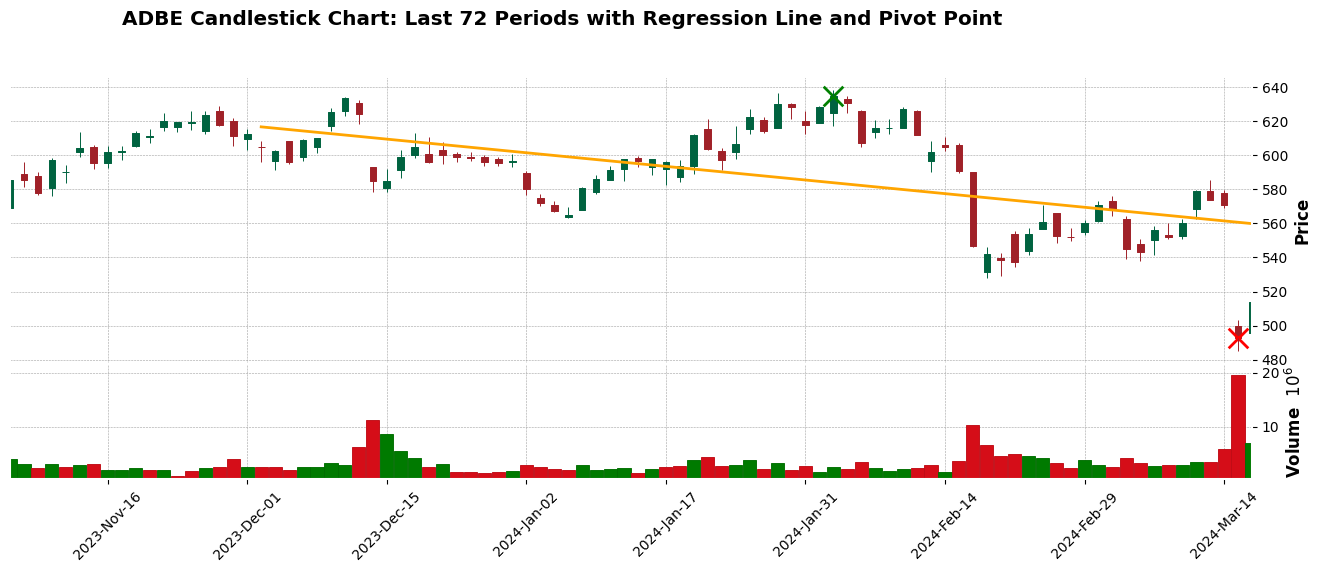

In [40]:
# Step X: chart it
last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
         figratio=(42, 14),
         xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
         addplot=apds)

mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [ ]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [ ]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [ ]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [ ]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [ ]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [ ]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [ ]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [ ]:
# chart_historical_df.head(5)

In [ ]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [ ]:
# # date column check data type
# chart_historical_df.index

In [ ]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [ ]:
# chart_historical_df.index

In [ ]:
# chart_historical_df.head(5)

In [ ]:
# print(tv_L2_df.columns)

In [ ]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [ ]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [ ]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [ ]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [ ]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [ ]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [ ]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [ ]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [ ]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [ ]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [ ]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [ ]:
# # check the date column type
# chart_historical_df.index

In [ ]:
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
# tl_pre_df = tl_pre_df.iloc[:,:6]

# tl_pre_df.head(5)

In [ ]:
# # get the date column type
# tl_pre_df.index

In [ ]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [ ]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)